<a href="https://colab.research.google.com/github/mrmcduff/HuggingFace-Sentiment-Classifier/blob/main/sentiment_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets peft accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [68]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import load_dataset
from peft.mapping import get_peft_model
from peft.tuners.lora import LoraConfig
from peft.utils.peft_types import TaskType
from accelerate import Accelerator
import numpy as np

To make things interesting, rather than using `gpt2`, I opted for the `finbert` model to look at financial datasets.

In [56]:
model_name = "ProsusAI/finbert"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set pad token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.config.pad_token_id = tokenizer.pad_token_id

In [57]:
print(tokenizer.pad_token)

[PAD]


In [58]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

We are using the financial phrasebank dataset found at https://huggingface.co/datasets/takala/financial_phrasebank . The argument for `sentences_allagree` means that all of the human reviewers of the selected sentences agreed as to its classification. We could alternately have chosen for more than half to agree, more than 2/3, or more than 3/4.

In [6]:
dataset = load_dataset("financial_phrasebank", "sentences_allagree")

README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

The repository for financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/financial_phrasebank.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

Taking a quick look at our dataset:

In [59]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

Our dataset does not by itself have a train/test split, so we'll have to create one.

In [52]:
train_test = dataset["train"].train_test_split(test_size=0.2, seed=42)

In [24]:
splits = ["train", "test"]

In [60]:
tokenized_dataset = {}
for split in splits:
    tokenized_dataset[split] = train_test[split].map(
        lambda x: tokenizer(x["sentence"], truncation=True), batched=True
    )

Map:   0%|          | 0/1811 [00:00<?, ? examples/s]

Map:   0%|          | 0/453 [00:00<?, ? examples/s]

It is worth noting here that this isn't a positive/negative classification task -- there are three labels: negative, neutral, and positive.

In [61]:
tokenized_dataset["train"]

Dataset({
    features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1811
})

Please note that the base model evaluation is done at the same time as the PEFT model evaluation, lower in the notebook. There are appropriate comparisons and confusion matrices shown for each.

In [62]:
training_args = TrainingArguments(
    output_dir="./results",
    report_to="none",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    eval_strategy="epoch",
)


In [63]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
)

In [32]:
peft_model = get_peft_model(model, peft_config)

Here, we create a trainer to actually use our PEFT on along with a trainer whose sole purpose is to evaluate the base model.

In [74]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    processing_class=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)
base_trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_dataset["test"],
    processing_class=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

In [48]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.661643,0.668874
2,No log,0.479656,0.832230


TrainOutput(global_step=228, training_loss=0.7528585467422217, metrics={'train_runtime': 35.4481, 'train_samples_per_second': 102.177, 'train_steps_per_second': 6.432, 'total_flos': 111038775766200.0, 'train_loss': 0.7528585467422217, 'epoch': 2.0})

In [49]:
trainer.evaluate()

{'eval_loss': 0.4796564280986786,
 'eval_accuracy': 0.8322295805739515,
 'eval_runtime': 1.7031,
 'eval_samples_per_second': 265.983,
 'eval_steps_per_second': 17.028,
 'epoch': 2.0}

In [50]:
base_trainer.evaluate()

{'eval_loss': 3.929110050201416,
 'eval_model_preparation_time': 0.0134,
 'eval_accuracy': 0.013245033112582781,
 'eval_runtime': 2.3251,
 'eval_samples_per_second': 194.826,
 'eval_steps_per_second': 12.472}

In [94]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [95]:
def get_predictions(trainer, dataset):
    predictions = trainer.predict(dataset)
    return np.argmax(predictions.predictions, axis=-1)

base_preds = get_predictions(base_trainer, tokenized_dataset["test"])
fine_tuned_preds = get_predictions(trainer, tokenized_dataset["test"])
true_labels = train_test["test"]["label"]

print("Base Model Performance:")
print(classification_report(true_labels, base_preds))
print("\nFine-tuned Model Performance:")
print(classification_report(true_labels, fine_tuned_preds))

Base Model Performance:
              precision    recall  f1-score   support

           0       0.01      0.01      0.01        73
           1       0.06      0.02      0.03       280
           2       0.00      0.00      0.00       100

    accuracy                           0.01       453
   macro avg       0.02      0.01      0.01       453
weighted avg       0.04      0.01      0.02       453


Fine-tuned Model Performance:
              precision    recall  f1-score   support

           0       0.59      0.32      0.41        73
           1       0.84      0.97      0.90       280
           2       0.91      0.81      0.86       100

    accuracy                           0.83       453
   macro avg       0.78      0.70      0.72       453
weighted avg       0.82      0.83      0.81       453



In [96]:
print("\nConfusion Matrix - Base Model:")
base_cm = confusion_matrix(true_labels, base_preds)
print(confusion_matrix(true_labels, base_preds))
print("\nConfusion Matrix - Fine-tuned Model:")
ft_cm = confusion_matrix(true_labels, fine_tuned_preds)
print(confusion_matrix(true_labels, fine_tuned_preds))



Confusion Matrix - Base Model:
[[  1  72   0]
 [  9   5 266]
 [100   0   0]]

Confusion Matrix - Fine-tuned Model:
[[ 23  49   1]
 [  0 273   7]
 [ 16   3  81]]


In [88]:
import matplotlib.pyplot as plt

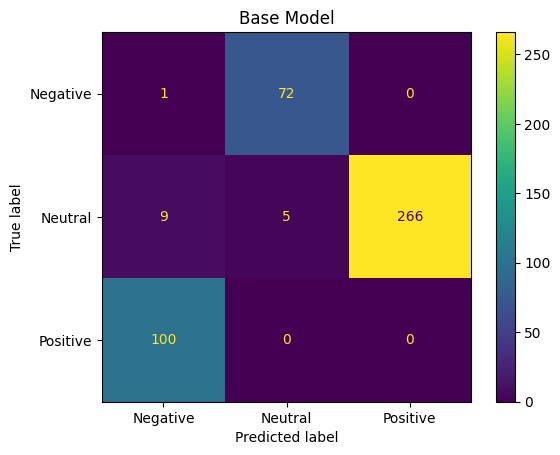

In [92]:
# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=base_cm, display_labels=['Negative', "Neutral", "Positive"])

# Plot the confusion matrix
disp.plot()
plt.title("Base Model")
plt.show()

It is worth noting above that the base model misclassified almost all neutral items as "positive."

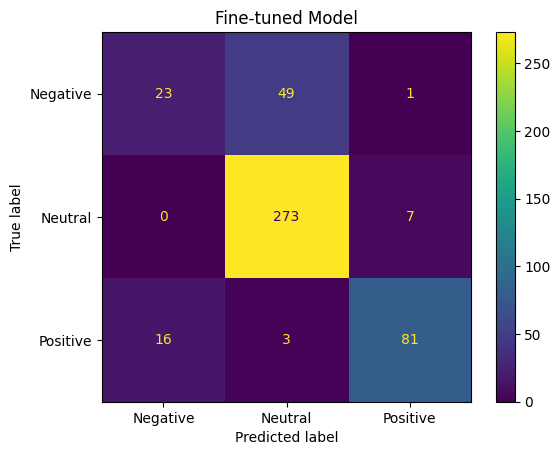

In [93]:
# Create a ConfusionMatrixDisplay object
ft_disp = ConfusionMatrixDisplay(confusion_matrix=ft_cm, display_labels=['Negative', "Neutral", "Positive"])

# Plot the confusion matrix
ft_disp.plot()
plt.title("Fine-tuned Model")
plt.show()

Our fine-tuned model wasn't perfect, but there are a lot more results landing on the diagonal of this matrix, which is what we'd like to see to call it "improved."

In [82]:
items_for_manual_review = tokenized_dataset["test"].select(
    [0, 1, 22, 31, 43, 200]
)

results = trainer.predict(items_for_manual_review)
df = pd.DataFrame(
    {
        "sentence": [item["sentence"] for item in items_for_manual_review],
        "predictions": results.predictions.argmax(axis=1),
        "labels": results.label_ids,
    }
)
# Show all the cell
pd.set_option("display.max_colwidth", None)
df

,sentence,predictions,labels
0,"Indigo and Somoncom serve 377,000 subscribers and had a market share of approximately 27 % as of May 2007 .",1,1
1,The sellers were EOSS Innovationsmanagement and a group of private individuals .,1,1
2,"Tallink Silja attributes the significant drop to problems with the booking system that was taken into operation in October , the sale of trailer ferry ` Sky Wind ' and the route between Stockholm and Riga , which has won passengers from the Helsinki-Stockholm route .",1,0
3,"Tekla 's defense business employs over 20 persons and is located in Espoo , Finland .",1,1
4,"`` We 're delighted with the move '' says Morna Cowie , co-owner , above , `` it 's double the size of our current shop and has a lovely feel to it . ''",2,2
5,Stora Enso Oyj said its second-quarter result would fall by half compared with the same period in 2007 .,1,0
